# Build with Mixtral-8x7B-Instruct-v0.1 & Haystack

_Colab by Tuana Celik - ([LI](https://www.linkedin.com/in/tuanacelik/) & [Twitter](https://twitter.com/tuanacelik))_


Quick guide to building with the new `Mixtral-8x7B-Instruct-v0.1` model by Mistral AI.


**Why is Mixtral different?**

This is quite a cool new model. It's the first of its kind as an open-source model in that it is a _mixture_ (get _Mix_ tral) of 8 7B parameter models. This [article on Hugging Face](https://huggingface.co/blog/moe) describes this phenomenon way better and in way more detail than I can. The idea is that it's a mixture of 8 different "experts", with a router that routes a query to a given expert (not entirely accurate, but a good way to simplify). This means not all 8 models are inferenced, making it remarkably fast too!



1. Use the [`HuggingFaceAPIGenerator`](https://docs.haystack.deepset.ai/docs/huggingfaceapigenerator) to query the model on its own
2. Add the generator to a full RAG Pipeline (on the web)


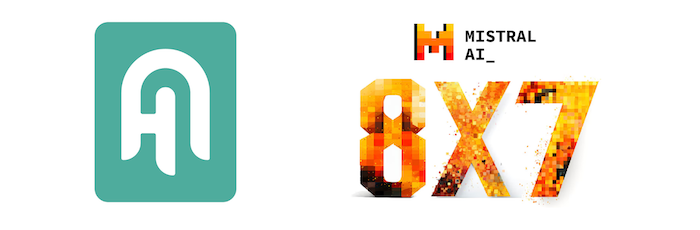
### Install dependencies

In [ ]:
!pip install haystack-ai trafilatura sentence_transformers "huggingface_hub>=0.22.0"

## Prompt the Model - Standalone

We are using Hugging Face Serverless Inference API.

- This requires an API key: https://huggingface.co/settings/tokens
- You should also accept Mistral conditions here: https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1


In [ ]:
import os
from getpass import getpass

os.environ["HF_API_TOKEN"] = getpass("Enter Hugging Face token: ")

In [ ]:
from haystack.components.generators import HuggingFaceAPIGenerator

generator = HuggingFaceAPIGenerator(
    api_type="serverless_inference_api",
    api_params={"model": "mistralai/Mixtral-8x7B-Instruct-v0.1"})


In [ ]:
result = generator.run("What's Natural Language Processing?", generation_kwargs={"max_new_tokens": 350})
print(result["replies"][0])

## Use the Model in a full RAG pipeline (on the web)

Here, we will be using the same `generator` component as the above, in a full RAG pipeline. You can change this pipeline to use your own data source (such as a vector databse, Notion, documentation) instead of the [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher) we are using here.

In [ ]:
from haystack.components.fetchers.link_content import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack import Pipeline

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
document_splitter = DocumentSplitter(split_by="word", split_length=50)
similarity_ranker = TransformersSimilarityRanker(top_k=3)

prompt_template = """
According to these documents:

{% for doc in documents %}
  {{ doc.content }}
{% endfor %}

Answer the given question: {{question}}
Answer:
"""
prompt_builder = PromptBuilder(template=prompt_template)

pipeline = Pipeline()
pipeline.add_component("fetcher", fetcher)
pipeline.add_component("converter", converter)
pipeline.add_component("splitter", document_splitter)
pipeline.add_component("ranker", similarity_ranker)
pipeline.add_component("prompt_builder", prompt_builder)
pipeline.add_component("llm", generator)

pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "splitter.documents")
pipeline.connect("splitter.documents", "ranker.documents")
pipeline.connect("ranker.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm.prompt")

In [ ]:
question = "What do graphs have to do with Haystack?"
result = pipeline.run({"prompt_builder": {"question": question},
                   "ranker": {"query": question},
                   "fetcher": {"urls": ["https://haystack.deepset.ai/blog/introducing-haystack-2-beta-and-advent"]},
                    "llm":{"generation_kwargs": {"max_new_tokens": 350}}})

print(result['llm']['replies'][0])